# Import libraries and load model

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pybedtools
from pybedtools import BedTool
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
import shap
import utils
%matplotlib inline

2024-02-27 15:07:41.492750: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term


/staging/leuven/stg_00002/lcb/nkemp/software/anaconda3/envs/DeepBrain3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


If you're using a GPU, the following commands should list the GPU as available.

In [4]:
!nvidia-smi
print(tf.config.list_physical_devices())

Tue Feb 27 15:09:37 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:C0:00.0 Off |                    0 |
| N/A   34C    P0    62W / 500W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

2024-02-27 15:09:38.243159: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-27 15:09:38.286761: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-27 15:09:38.584676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:c0:00.0 name: NVIDIA A100-SXM4-80GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.15GiB deviceMemoryBandwidth: 1.85TiB/s
2024-02-27 15:09:38.584858: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-02-27 15:09:39.554626: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-27 15:09:39.559277: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

In [10]:
# Load the background sequences
background_seqs_location = 'data/background_seqs.pkl'
with open(background_seqs_location, "rb") as f:
    background_seqs = pickle.load(f)

# Set the model directory and name
model_directory = '.models/DeepChickenBrain/'
model_name = 'DeepChickenBrain'

# Load the DeepChickenBrain model
DeepChickenBrain = utils.load_model(model_directory, model_name)

# Randomly select a subset of data for explanation
rn = np.random.choice(background_seqs.shape[0], 500, replace=False)

# Create a DeepExplainer for the DeepChickenBrain model
explainer_DeepChickenBrain = shap.DeepExplainer((DeepChickenBrain.inputs, DeepChickenBrain.layers[-1].output), background_seqs[rn])

# Print the summary of the DeepChickenBrain model
DeepChickenBrain.summary()

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
2024-02-27 15:11:07.689978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-27 15:11:17.466505: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-02-27 15:11:18.303136: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2024-02-27 15:12:06.356274: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-02-27 15:12:06.587202: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-02-27 15:12:16.200878: I tensorflow/stream

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 4)]          0         
_________________________________________________________________
model_1 (Functional)         (None, 1024)              10567680  
_________________________________________________________________
intermediate_dense (Dense)   (None, 512)               524288    
_________________________________________________________________
batchnorm (BatchNormalizatio (None, 512)               2048      
_________________________________________________________________
intermediate_relu (Activatio (None, 512)               0         
_________________________________________________________________
intermediate_dropout2 (Dropo (None, 512)               0         
_________________________________________________________________
classification_layer (Dense) (None, 20)                1026

# Getting region predictions and contribution scores

For scoring a region from any species, you will need its genome. To download the chicken genome (galGal6) for example, you can use https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000002315.5/ . Put the genome in the data/ subdirectory. For mouse genome, use mm10, for human, hg38.

In [11]:
# Define the location of the region (chr18, 61108475-61108975) in mm10 genome
location = ("chr18", 61108475, 61108975)  # mm10 FIRE enhancer

# Specify the path to the genome file containing the fasta (.fa), and optionally fasta index (.fai), file(s)
genomefile_path = "data/genome.fa" 

# Encode the sequence in one-hot format using the BedTool.seq() function
seq_onehot = utils.one_hot_encode_along_row_axis(BedTool.seq(location, genomefile_path))

## Plotting prediction scores

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


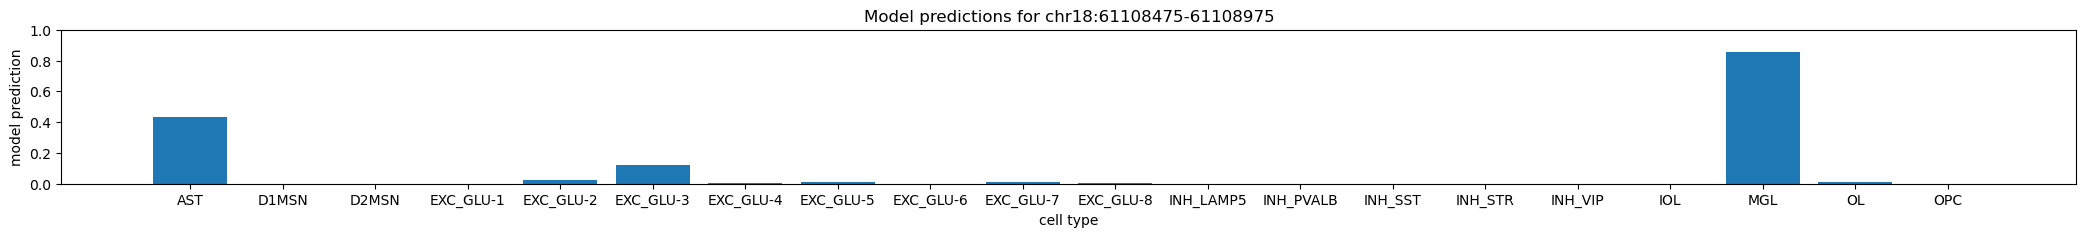

In [12]:
import json

# Load DeepChickenBrain classes
with open('models/model_classes.json', 'r') as f:
    all_model_classes = json.load(f)
model_classes = all_model_classes['DeepChickenBrain']

# Plot model predictions
prediction = utils.plot_model_predictions(model=DeepChickenBrain, location=location, seq_onehot=seq_onehot, model_classes=model_classes)

## Plotting region contribution scores

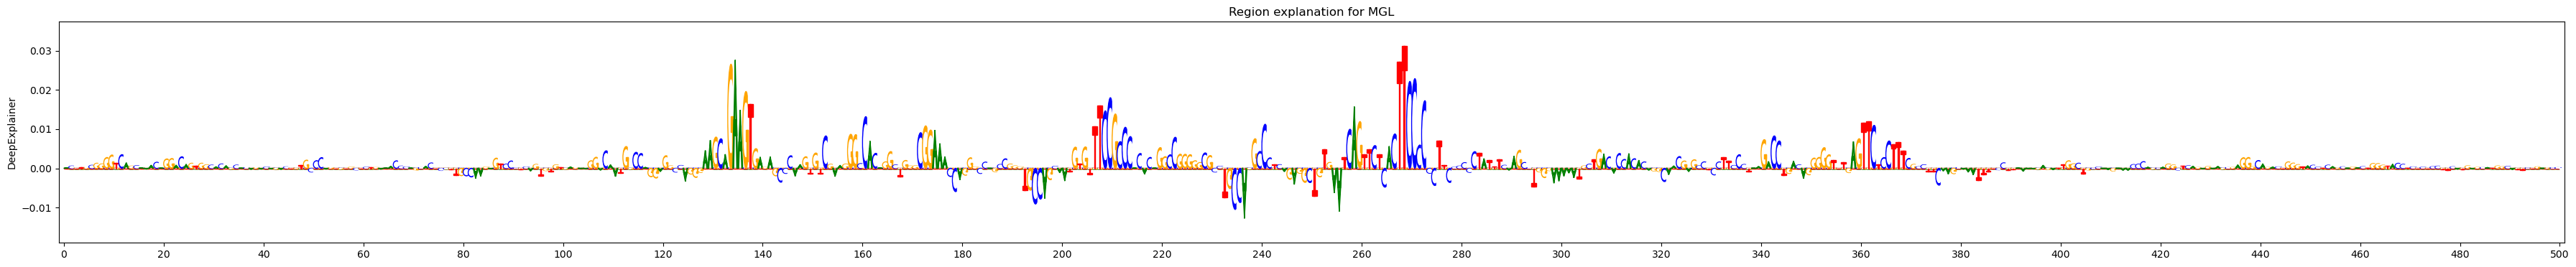

In [13]:
ntrack = 1
fig = plt.figure(figsize=(45,ntrack*4))

# Define cell type and the explainer from the chosen model
ct='MGL'
explainer=explainer_DeepChickenBrain

# Plot DeepExplainer nucleotide contribution scores
track_no=1
ax1, scores = utils.plot_deepexplainer_givenax(explainer=explainer, fig=fig, ntrack=ntrack, track_no=track_no, seq_onehot=seq_onehot, cell_type=ct, class_names=model_classes)


## Calculating Spearman correlation between model contribution scores

### Correlation between cell types within a model

In [14]:
from scipy.stats import spearmanr

# Calculate the scores for cell type 'MGL'
_, scoresA = utils.plot_deepexplainer_givenax(explainer=explainer_DeepChickenBrain, fig=None, ntrack=None, track_no=None, seq_onehot=seq_onehot, cell_type='MGL', class_names=model_classes, plot=False)

# Calculate the scores for cell type 'OL'
_, scoresB = utils.plot_deepexplainer_givenax(explainer=explainer_DeepChickenBrain, fig=None, ntrack=None, track_no=None, seq_onehot=seq_onehot, cell_type='OL', class_names=model_classes, plot=False)
# Calculate the Spearman correlation and p-value
spearman_corr, p_value = spearmanr(scoresA, scoresB)

# Print the results
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {p_value}")

Spearman correlation: 0.085, p-value: 0.05613285855819031


### Correlation between cell types of two models

In [16]:
# Load the DeepMouseBrain1 model
DeepMouseBrain1 = utils.load_model('.models/DeepMouseBrain/', 'DeepMouseBrain1')
# Get the model classes for the DeepMouseBrain1 model
mouse_model_classes = all_model_classes['DeepMouseBrain1']
# Create a DeepExplainer for the DeepMouseBrain1 model
explainer_DeepMouseBrain1 = shap.DeepExplainer((DeepMouseBrain1.inputs, DeepMouseBrain1.layers[-1].output), background_seqs[rn])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [17]:
# Calculate the contribution scores for cell type 'MGL' using the DeepChickenBrain model
_, scoresA = utils.plot_deepexplainer_givenax(explainer=explainer_DeepChickenBrain, fig=None, ntrack=None, track_no=None, seq_onehot=seq_onehot, cell_type='MGL', class_names=model_classes, plot=False)
# Calculate the contribution scores for cell type 'MGL' using the DeepMouseBrain1 model
_, scoresB = utils.plot_deepexplainer_givenax(explainer=explainer_DeepMouseBrain1, fig=None, ntrack=None, track_no=None, seq_onehot=seq_onehot, cell_type='MGL', class_names=mouse_model_classes, plot=False)

# Calculate the Spearman correlation and p-value between the contribution scores
spearman_corr, p_value = spearmanr(scoresA, scoresB)

# Print the Spearman correlation and p-value
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {p_value}")

Spearman correlation: 0.495, p-value: 3.248213973984467e-32
